## 2.1 Data Cleaning

### 2.1.1 Finding missing values
**Goal:** To identify which features have missing values and percentage of missing data for each feature

In [35]:
import pandas as pd

# Loading the data
file_path = "../data/retail_data.csv"
data = pd.read_csv(file_path)

# Finding the total number of missing values in each column
missing_values = data.isnull().sum()


# Calculating the percentage of missing values in each column
missing_percentage = (missing_values / len(data)) * 100

# Combining into a single DataFrame for a better overview
missing_data_summary = pd.DataFrame({
    'Total Missing Values': missing_values,
    'Percentage Missing': missing_percentage
})

# Displaying columns with missing values
print(missing_data_summary[missing_data_summary['Total Missing Values'] > 0])

                  Total Missing Values  Percentage Missing
Transaction_ID                     333            0.110261
Customer_ID                        308            0.101983
Name                               382            0.126486
Email                              347            0.114897
Phone                              362            0.119864
Address                            315            0.104301
City                               248            0.082116
State                              281            0.093043
Zipcode                            340            0.112579
Country                            271            0.089732
Age                                173            0.057283
Gender                             317            0.104963
Income                             290            0.096023
Customer_Segment                   215            0.071190
Date                               359            0.118870
Year                               350            0.1158

**Key Insights by Feature**

**Identifiers (Transaction_ID, Customer_ID):**

Missing values in these columns could impact data integrity and merging operations. For example, if Transaction_ID or Customer_ID is missing, it may indicate incomplete records that could be dropped if they significantly affect the analysis.

**Contact Details (Name, Email, Phone):**

A comparatively higher percentage of missing Name, Email, and Phone might indicate privacy concerns or data entry issues. Depending on the analysis, imputing or dropping these may be needed, especially if these columns are not crucial for modeling.

**Demographic Information (Age, Gender, Income):**

Missing values in Age, Gender, and Income are notable, but not exceedingly high (0.057% to 0.105%). First we need to find if these missing values happened completely at Random (MCAR), or at Random (MAR) or not at Random (MNAR) and then can be imputed or handled accordingly.

**Transaction Details (Date, Time, Total_Purchases, Amount, Total_Amount):**

Date, Time, and Amount have missing values between 0.11% to 0.12%, which could indicate data entry inconsistencies or system errors. These features are crucial for trend analysis and modeling; imputation or dropping strategies need to be applied carefully to avoid bias.

**Product Details (Product_Category, Product_Brand):**

Missing product-related information could impact analysis related to product performance or customer preferences. Imputing these with a placeholder like "Unknown" or using mode imputation based on related features could be effective.

**Customer Segmentation (Customer_Segment):**

Missing values in Customer_Segment may affect customer profiling. These can be imputed using predictive models based on other demographic and transaction features.

**Ratings and Feedback:**

The missing values for Feedback and Ratings (about 6%) may indicate that not all transactions received ratings or feedback. Imputing them with a placeholder like "No Feedback" can maintain data integrity while preserving the original distribution.

### 2.1.2 Understanding the Types of Missing Data
**MCAR (Missing Completely at Random):** The missingness has no relationship with any other variables or the missing variable itself. This type of missingness is ideal as it allows for unbiased analyses.

**MAR (Missing at Random):** The missingness is related to observed data but not the value of the variable that is missing. For example, income might be missing more frequently for older customers but is not dependent on the missing value itself.

**MNAR (Missing Not at Random):** The missingness is related to the unobserved value itself or some unobserved factors. For example, high incomes might be missing because individuals choose not to disclose them.

### 2.1.3 Identifying the Nature of Missingness

**Goal:** To determine if the missingness is MCAR, MAR, or MNAR

#### Visual Analysis of Missing Values - Bar Chart

<Axes: >

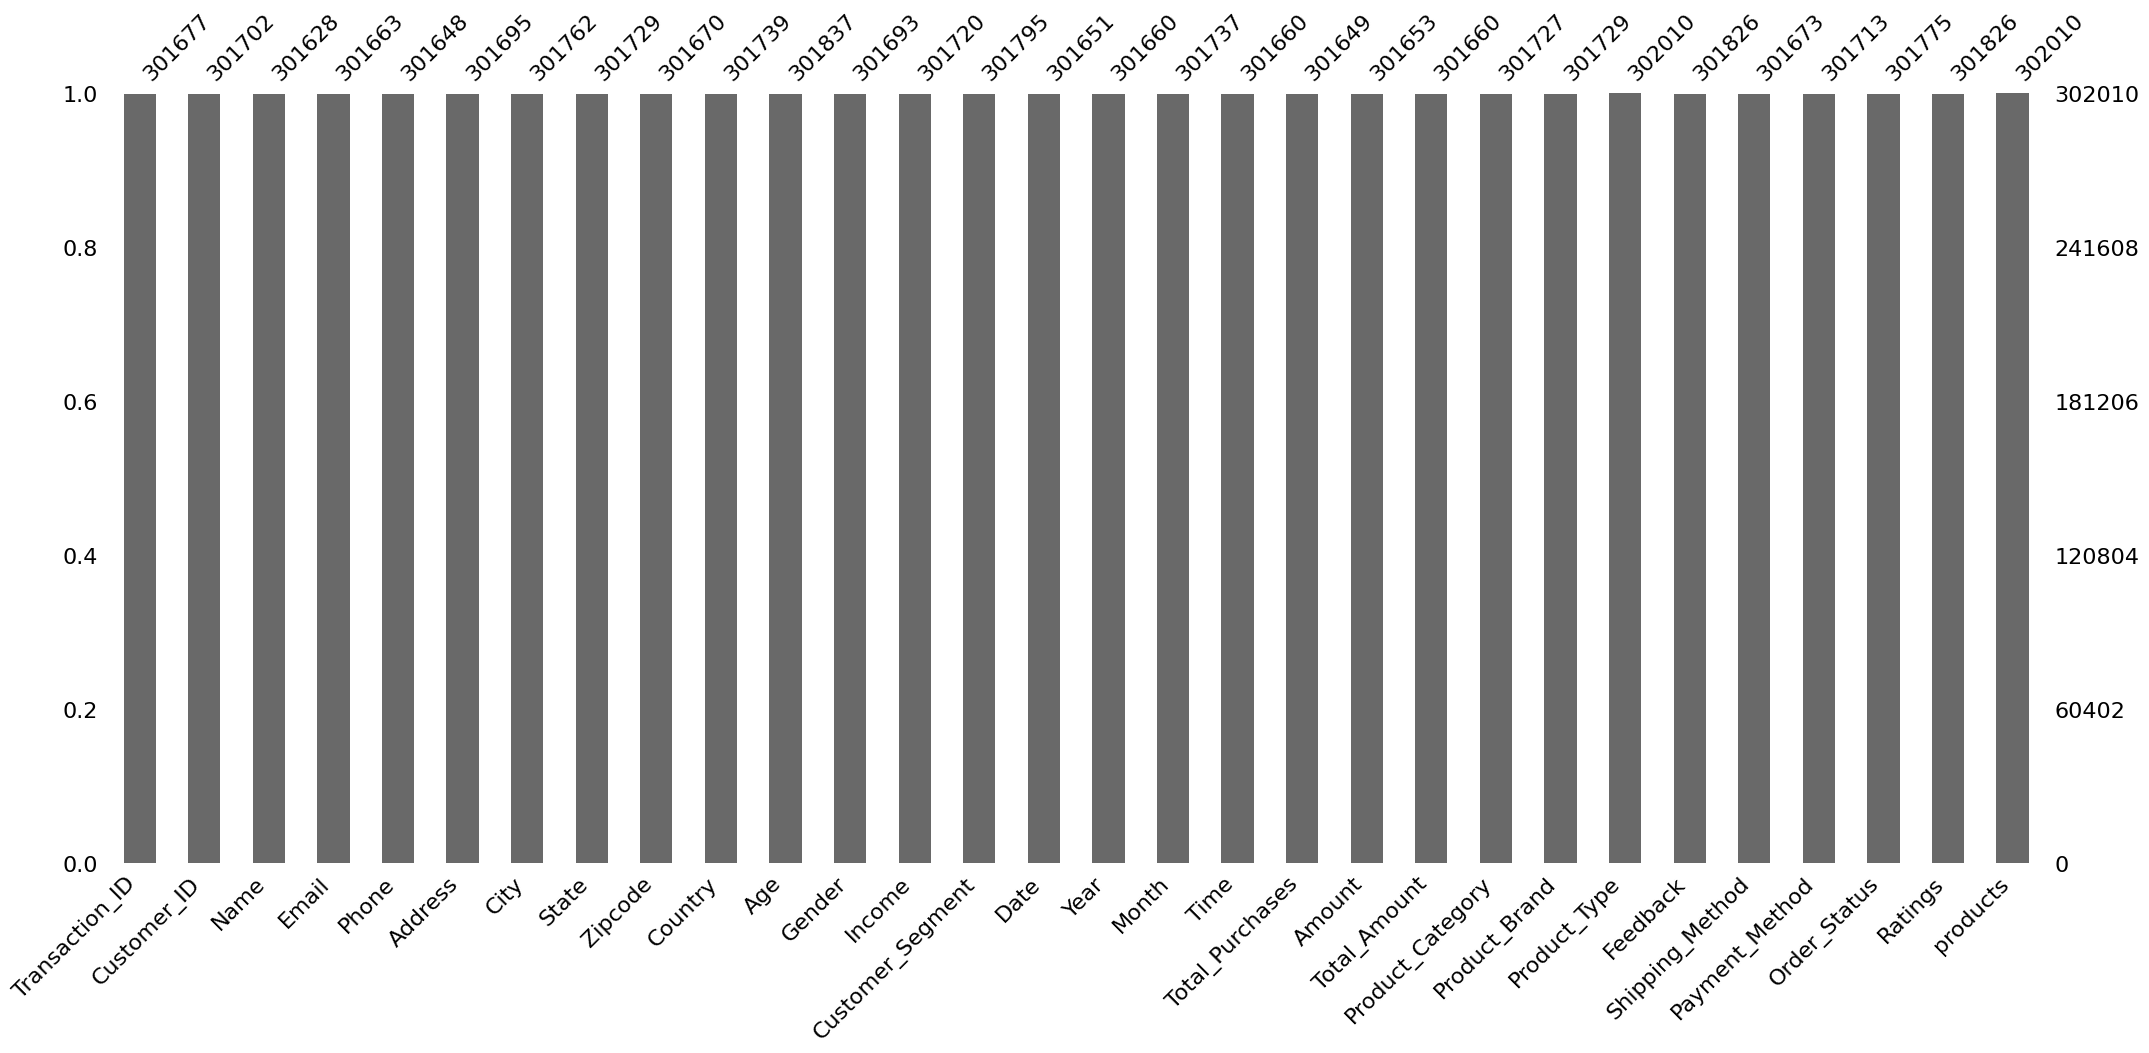

In [12]:
# Importing missingno library
import missingno as msno 

msno.bar(data)

**Insight:** Since only few values are missing (considering this is a simulated dataset), we dont see much of a different in the bar height of different features

#### Visual Analysis of Missing Values - Matrix

<Axes: >

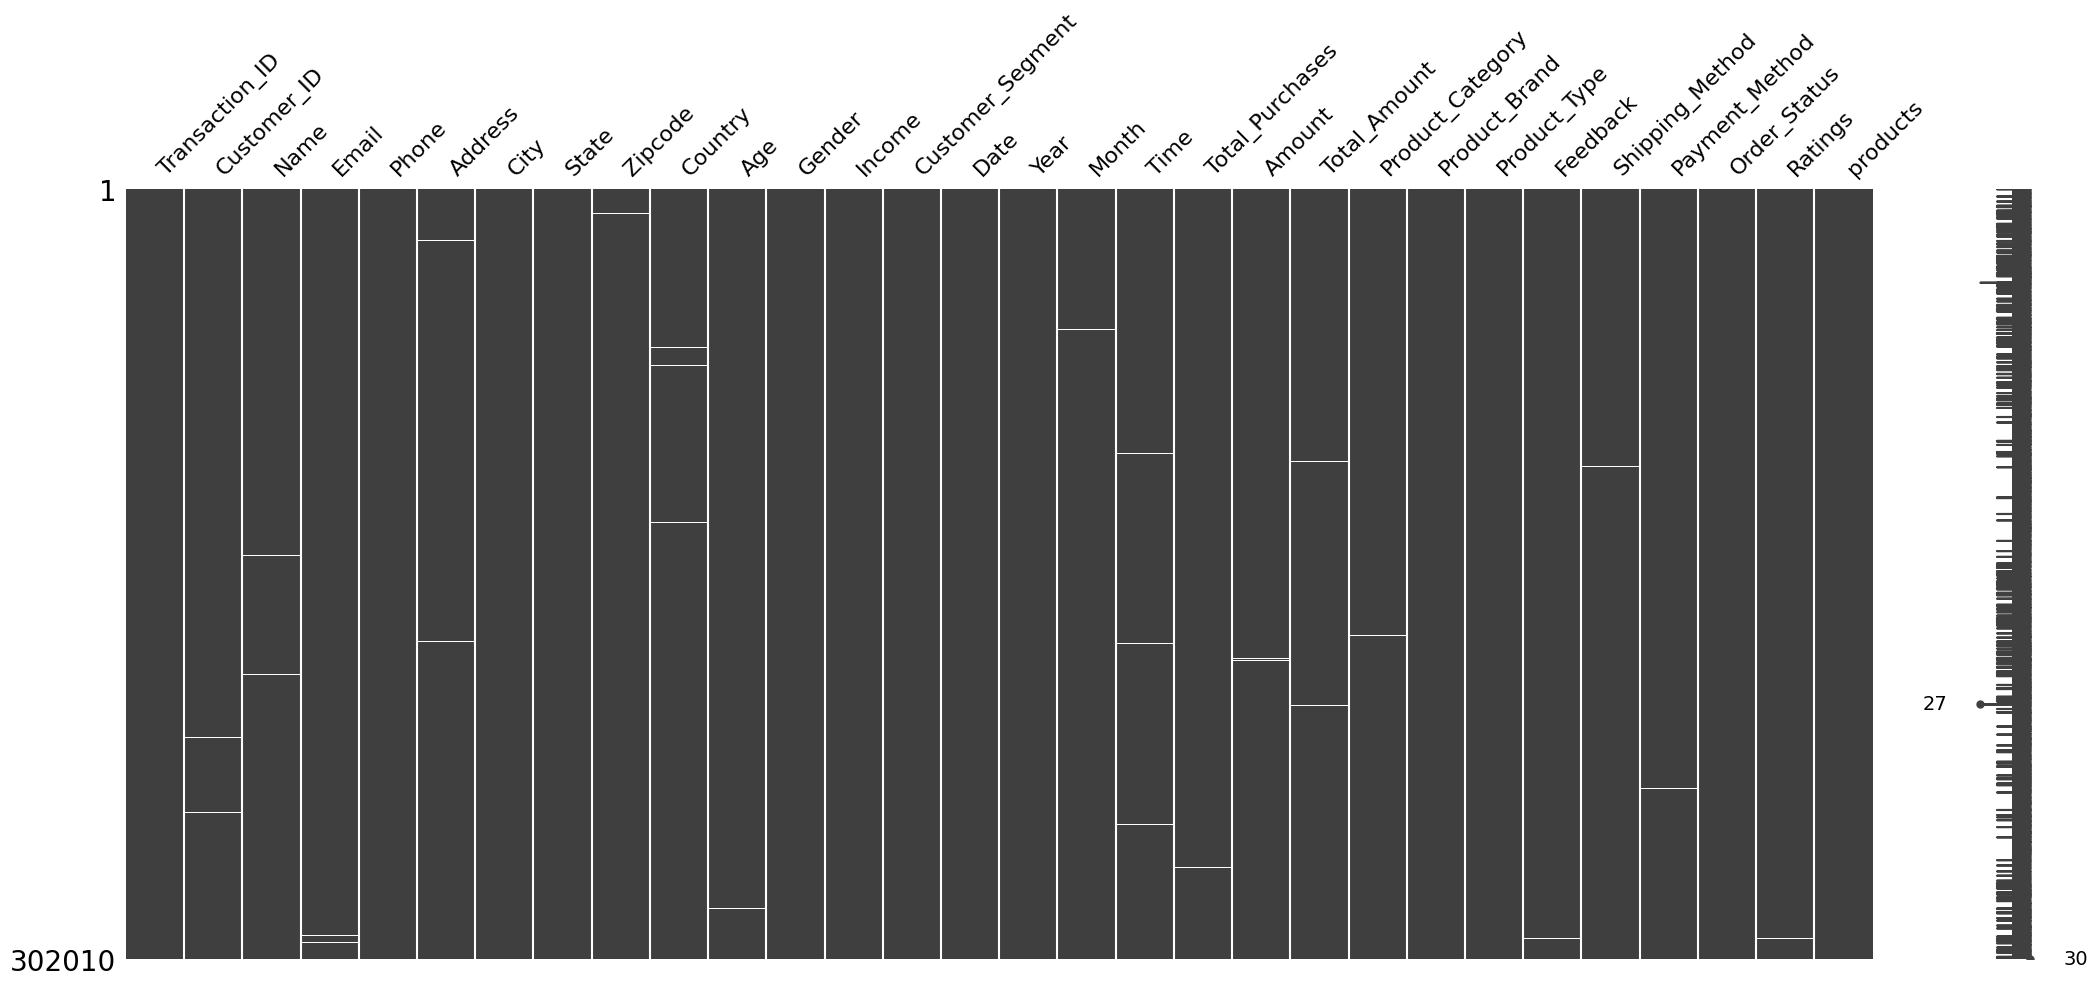

In [13]:
# Visualising missing values as a matrix 
msno.matrix(data) 


**Insight:** Not seeing any similar pattern of missing values between or within any features, can visualise the correlation heatmap to understand if one feature is dependant on another

#### Visual Analysis of Missing Values - Heatmap

<Axes: >

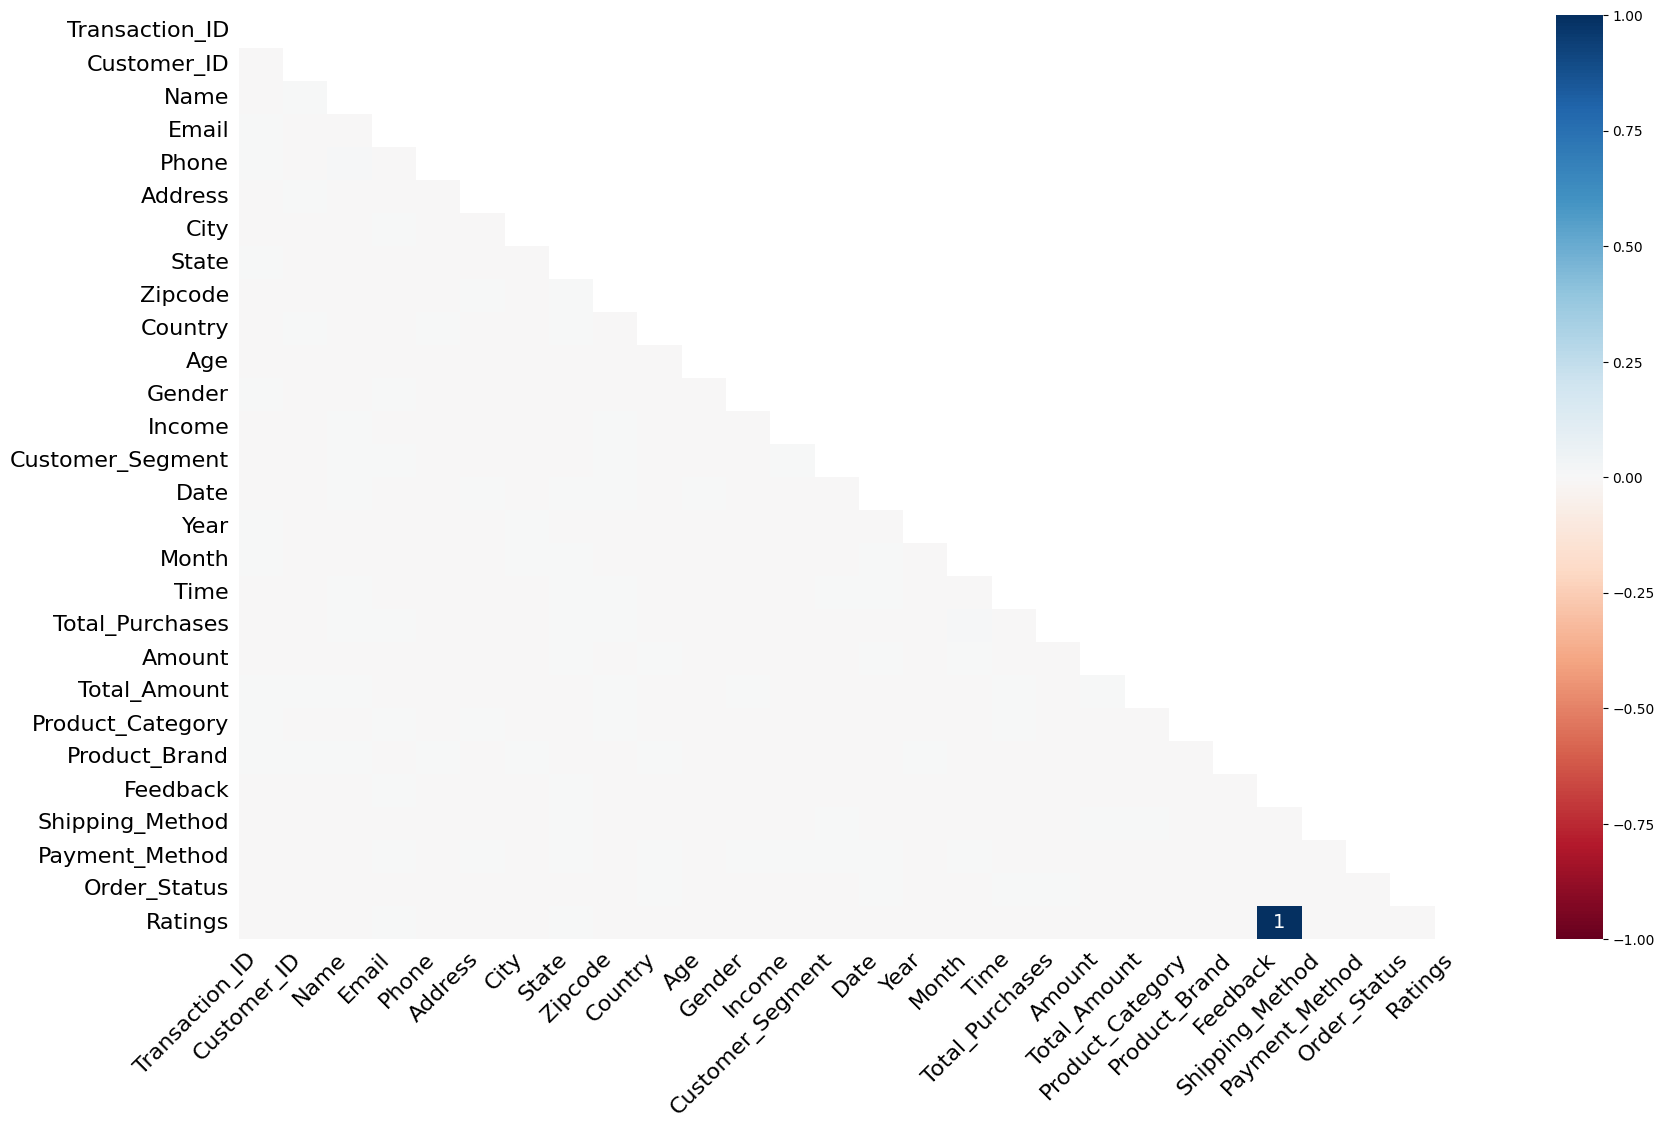

In [18]:
# Visualising the correlation between the number of 
# missing values in different features as a heatmap 
msno.heatmap(data) 

A value near -1 means if one variable appears then the other variable is very likely to be missing.

A value near 0 means there is no dependence between the occurrence of missing values of two variables.

A value near 1 means if one variable appears then the other variable is very likely to be present.

**Insight:** Since, there is only a corrrelation between feedback and ratings, we conclude that if feedback is present then ratings is also available for that record

#### Numerical features Correlation - Quantitative Analysis
**Why:**

- missingno.heatmap is great for an initial visual exploration of missing data patterns, helping to quickly identify any relationships.

- The correlation script goes a step further by quantifying those relationships, showing the strength of the correlation between missing data and other numerical columns. This is important to determine if a missing data pattern is MAR or correlated in a meaningful way.

In [40]:
# Creating binary indicators for missing values in each numerical column
numerical_data = data.select_dtypes(include=['number'])
missing_indicators = numerical_data.isnull().astype(int).add_suffix('_missing')

# Combine the original numerical data with the missing indicators
combined_data = pd.concat([numerical_data, missing_indicators], axis=1)

# Calculate the correlation matrix for the combined data
correlation_matrix = combined_data.corr()

print(correlation_matrix)

                                Transaction_ID  Customer_ID     Phone  \
Transaction_ID                        1.000000     0.004798  0.000515   
Customer_ID                           0.004798     1.000000 -0.000966   
Phone                                 0.000515    -0.000966  1.000000   
Zipcode                              -0.002964    -0.002478 -0.003076   
Age                                  -0.001630    -0.000162 -0.003498   
Year                                 -0.000039     0.000434  0.002556   
Total_Purchases                      -0.001718     0.003741 -0.000568   
Amount                               -0.003018     0.000342  0.000165   
Total_Amount                         -0.002469     0.002844 -0.000161   
Ratings                              -0.000318     0.001835 -0.000909   
Transaction_ID_missing                     NaN     0.002283 -0.000630   
Transaction_ID_missing                     NaN     0.002283 -0.000630   
Customer_ID_missing                   0.004937     

**What We’re Trying to Do:**

We want to see if the fact that a value is missing in one feature is related to values (or missingness) in other features. This helps us figure out if the missing values are random or follow a pattern.

**How We Approach It:**
Create Missing Indicators: We create new columns (_missing) that act as flags for whether a value is missing in the original feature (e.g., 1 if missing, 0 if present).
For example, if Income is missing in a row, the income_missing column for that row will be 1.
Calculate Correlation: We calculate the correlation between these missing indicators and other features (numerical data) to see if there’s a relationship.
A positive correlation means that as one feature's missingness increases, the likelihood of missingness in another feature also increases.
A negative correlation means the opposite—if one feature has missing values, the other feature is more likely to have non-missing values.

**What to look for:**

High Correlation: If income_missing or some feature_missing has a strong correlation (e.g., 0.5 or higher) with age, it suggests that missing income values might depend on the age of customers, indicating MAR (Missing at Random).

Low or Zero Correlation: If the correlation is close to zero, it suggests there is no significant relationship between missing values, indicating MCAR (Missing Completely at Random).

Correlation Among Missing Indicators: If income_missing correlates highly with phone_missing, it might suggest a relationship between missing data in Income and Phone.

**Insight:**

**Low Correlations with Missing Indicators:**
The correlations between missing indicators (e.g., Customer_ID_missing, Phone_missing) and numerical columns are close to zero. This suggests that the missingness of these columns does not have a strong linear relationship with other numerical data.
For example, Phone_missing correlates very weakly with features like Transaction_ID (0.000533) and Year (-0.000199).

**Conclusion:** 

All the missing values are poorly correlated meaning the missingness could have most likely be MCAR (Missing completely at random). This is acceptable because the dataset is a simulated one, may be real data would have some values in correlation. Hence we can handle this missing values in any way we like as it is unlikely to create bias.

PS: Can do sinmilar quantitative analysis for categorical features, but from the missing values correlation heatmap it is clear that there is no need for doing a quantitative analysis on categorical features as there is no dignificant correlation except for feedback with ratings

#### Catergorical Features - Feedback versus Ratings
**Goal:** Since we see a correlation of 1 between Feedback and RAtings, we can visualis this further to confirm that the missing value is caused either by MNAR or MAR instead of MCAR

##### **Correlation Analysis**
To check if the missingness in one feature correlates with the missingness or values of the other, indicating a potential MAR pattern.

In [59]:
data['Ratings_missing'] = data['Ratings'].isnull().astype(int)
data['Feedback_missing'] = data['Feedback'].isnull().astype(int)

# Correlation between missing indicators
correlation_missing = data[['Ratings_missing', 'Feedback_missing']].corr()
print("Correlation between missing indicators:")
print(correlation_missing)
print(60*'-')

# Correlation with numerical features
numerical_features = data.select_dtypes(include=['number'])
print("\nCorrelation of missing indicators with numerical features:")
print("\nRatings_missing:")
print(numerical_features.corrwith(data['Ratings_missing']))
print(60*'-')
print("\nFeedback_missing:")
print(numerical_features.corrwith(data['Feedback_missing']))


Correlation between missing indicators:
                  Ratings_missing  Feedback_missing
Ratings_missing               1.0               1.0
Feedback_missing              1.0               1.0
------------------------------------------------------------

Correlation of missing indicators with numerical features:

Ratings_missing:
Transaction_ID            0.000683
Customer_ID              -0.001211
Phone                    -0.000304
Zipcode                  -0.001517
Age                      -0.010093
Year                      0.002394
Total_Purchases          -0.001226
Amount                    0.001933
Total_Amount              0.000078
Ratings                        NaN
Transaction_ID_missing   -0.000820
Feedback_missing          1.000000
Ratings_missing           1.000000
dtype: float64
------------------------------------------------------------

Feedback_missing:
Transaction_ID            0.000683
Customer_ID              -0.001211
Phone                    -0.000304
Zipcode   

/Users/agalya.ayyadurai/Portfolio/Customer-Segmentation-Insights/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/agalya.ayyadurai/Portfolio/Customer-Segmentation-Insights/venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


**Insight:** We see that there is very less correlation with other numerical features versus Ratings and Feedback but the correlation between RAtings and Feedback is 1 suggesting if Feedback is unavailable Ratings are also missing for those records. This suggest most likely the missing is due to MAR (Missing At Random)

##### **Group mean checks for categorical features**
**Goal:** To check if missingness in Ratings or Feedback correlates with certain categories in other features (e.g., Income, Customer_Segment, Product_Category)


In [55]:
for cat_col in data.select_dtypes(include=['object']).columns:
    mean_missing_ratings = data.groupby(cat_col)['Ratings_missing'].mean()
    mean_missing_feedback = data.groupby(cat_col)['Feedback_missing'].mean()
    
    print(f"\nMean missingness for Ratings by {cat_col}:\n{mean_missing_ratings}")
    print(f"\nMean missingness for Feedback by {cat_col}:\n{mean_missing_feedback}")


Mean missingness for Ratings by Name:
Name
Aaron Adams        0.0
Aaron Aguilar      0.0
Aaron Alexander    0.0
Aaron Allen        0.0
Aaron Allen PhD    0.0
                  ... 
Zoe Smith          0.0
Zoe Stewart        0.0
Zoe Torres         0.0
Zoe Wade           0.0
Zoe Woodard        0.0
Name: Ratings_missing, Length: 159390, dtype: float64

Mean missingness for Feedback by Name:
Name
Aaron Adams        0.0
Aaron Aguilar      0.0
Aaron Alexander    0.0
Aaron Allen        0.0
Aaron Allen PhD    0.0
                  ... 
Zoe Smith          0.0
Zoe Stewart        0.0
Zoe Torres         0.0
Zoe Wade           0.0
Zoe Woodard        0.0
Name: Feedback_missing, Length: 159390, dtype: float64

Mean missingness for Ratings by Email:
Email
Aaron100@gmail.com    0.0
Aaron10@gmail.com     0.0
Aaron11@gmail.com     0.0
Aaron12@gmail.com     0.0
Aaron13@gmail.com     0.0
                     ... 
Zoe93@gmail.com       0.0
Zoe95@gmail.com       0.0
Zoe96@gmail.com       0.0
Zoe97@gmail.com 

##### **Compare distributions**
**Goal:** To compare the distributions of related features for rows where Ratings and Feedback are missing versus not missing to identify MNAR patterns. 

**Note:** Just checking against the feature Total_Amount, but can be done for any feature to see any MNAR patterns (but since this mostl likely has so far indicated MAR patterns, we are just comparing distributions against one feature to see how it looks like

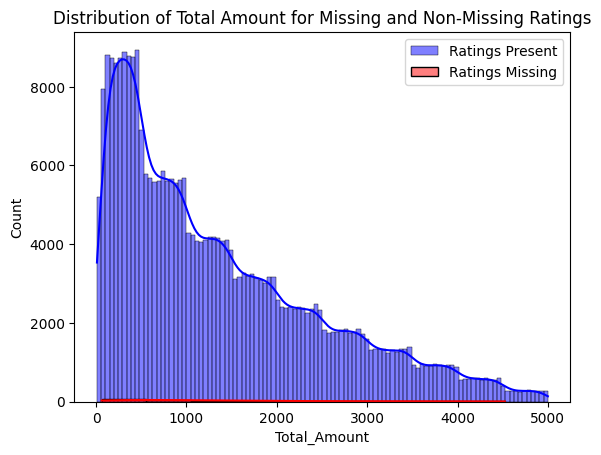

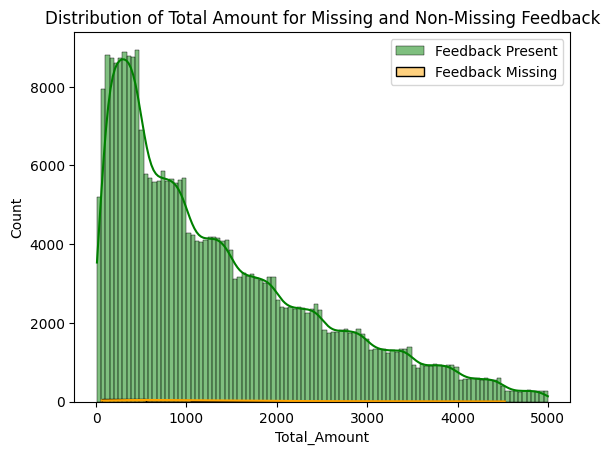

In [54]:
import seaborn as sns

# Distribution of Total_Amount feature when Ratings are missing or not missing
sns.histplot(data[data['Ratings'].notnull()]['Total_Amount'], color='blue', kde=True, label='Ratings Present')
sns.histplot(data[data['Ratings'].isnull()]['Total_Amount'], color='red', kde=True, label='Ratings Missing')
plt.legend()
plt.title('Distribution of Total Amount for Missing and Non-Missing Ratings')
plt.show()

# Similarly, for Feedback
sns.histplot(data[data['Feedback'].notnull()]['Total_Amount'], color='green', kde=True, label='Feedback Present')
sns.histplot(data[data['Feedback'].isnull()]['Total_Amount'], color='orange', kde=True, label='Feedback Missing')
plt.legend()
plt.title('Distribution of Total Amount for Missing and Non-Missing Feedback')
plt.show()

**Insight:** From the above analysis, the missing values in Ratings and Feedback can be considered as MAR and these values can be imputed accordingly

In [ ]:
###